In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import pyphi # needs nonbinary install
pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.MEASURE = 'AID'
pyphi.config.USE_SMALL_PHI_DIFFERENCE_FOR_CES_DISTANCE = True
pyphi.config.ASSUME_CUTS_CANNOT_CREATE_NEW_CONCEPTS = True
pyphi.config.WELCOME_OFF = True

from temporal_emergence import TPMMaker, CoarseGrainer, PhiCalculator, DataGenerator, Helpers


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [2]:

"""
So Nao wants to test what happens in the theoretical case when we get the TPM with data that doesn't 'line up' with the actual step-size of the system. 

So we need a TPM that exhibits emergence and can then generate data for us from which we read back.
"""

# First the original theoretical TPM. This governs the behaviour of the system over timesteps of size 2.
# The problem with this is that it can't actually generate data because it's so deterministic for the 33 state.
micro_TPM = np.array([
    # 00, 10, 20, 30, 01, 11, 21, 31, 02, 12, 22, 32, 03, 13, 23, 33
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #00
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #10
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #20
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1/3,1/3,1/3,0], #30
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #01
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #11
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #21
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1/3,1/3,1/3,0], #31
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #02
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #12
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #22
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1/3,1/3,1/3,0], #32
    [ 0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  0], #03
    [ 0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  0], #13
    [ 0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  0], #23
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1], #33

])

# So let's inject some noise to the TPM, small enough to keep the emergence property, but large enough to give us some
# nonstationary data. 

# NOISE PARAMETER, percent noise
pn = 0.1
l = micro_TPM.shape[0]
def noise(x,pn,l):
    return (1-pn) * x + pn / l
    
micro_TPM_noised = np.array([noise(xi,pn,l) for xi in micro_TPM])

<Figure size 432x288 with 0 Axes>

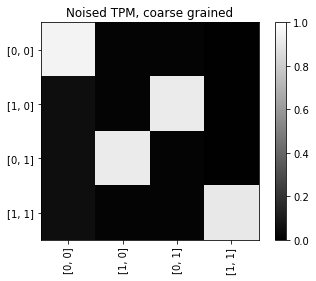

<Figure size 432x288 with 0 Axes>

In [5]:

num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
coarse_grained_TPM = CoarseGrainer.coarse_grain_nonbinary_TPM(micro_TPM_noised, state_map, num_states_per_elem)
states = Helpers.get_nary_states(2,2)
states = [str(list(reversed(state))) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(coarse_grained_TPM,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Noised TPM, coarse grained")
plt.colorbar()
plt.figure()


In [3]:
# Now let's generate some data using the noised TPM. 
bitlen = 10**5
base = 4

datagen = DataGenerator(micro_TPM_noised, base)
timeseries = datagen.generate_timeseries(bitlen)


In [9]:
# Now let's get a TPM back and coarse grain it
TPM, _ = TPMMaker.get_TPM_nonbinary(timeseries, 2, 2, 4000)

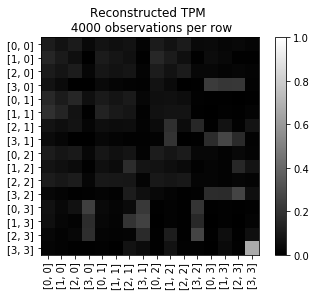

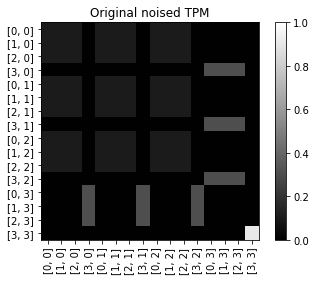

In [10]:
"""plt.imshow(TPM,cmap='gray',extent=None)
plt.title("Reconstructed TPM \n 4000 observations per row")
plt.figure()
plt.title("Original noised TPM")
plt.imshow(micro_TPM_noised,cmap='gray',extent=None)
"""

states = Helpers.get_nary_states(2,4)
states = [str(list(reversed(state))) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(TPM,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Reconstructed TPM \n 4000 observations per row")
plt.colorbar()
plt.figure()
states = [str(state) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(micro_TPM_noised,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Original noised TPM")
plt.colorbar()

<Figure size 432x288 with 0 Axes>

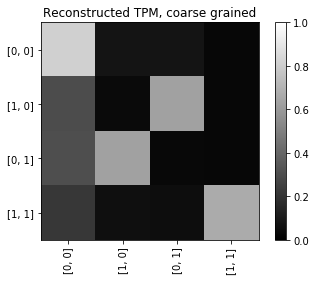

<Figure size 432x288 with 0 Axes>

In [11]:
# Let's also show the coarse grained reconstructed TPM
num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
coarse_grained_TPM = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM, state_map, num_states_per_elem)
states = Helpers.get_nary_states(2,2)
states = [str(list(reversed(state))) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(coarse_grained_TPM,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Reconstructed TPM, coarse grained")
plt.colorbar()
plt.figure()


In [12]:
micro_phi_recons = PhiCalculator.get_micro_average_phi(TPM, verbose=False)
macro_phi_recons = PhiCalculator.get_macro_average_phi(TPM, verbose=False)

print("\n")
print("MACRO PHI, RECONSTRUCTED: ", macro_phi_recons)
print("MICRO PHI, RECONSTRUCTED: ", micro_phi_recons)

micro_phi_actual = PhiCalculator.get_micro_average_phi(micro_TPM_noised, verbose=False)
macro_phi_actual = PhiCalculator.get_macro_average_phi(micro_TPM_noised, verbose=False)

print("\n")
print("MACRO PHI, ACTUAL: ", macro_phi_actual)
print("MICRO PHI, ACTUAL: " ,micro_phi_actual)


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

MACRO PHI, RECONSTRUCTED:  1.02556975
MICRO PHI, RECONSTRUCTED:  0.714290875
                                                                

MACRO PHI, ACTUAL:  1.7187039999999998
MICRO PHI, ACTUAL:  1.0575045


### Next, we need to do analysis of the full-shift sampling, to see if that completely destroys the emergence

In [5]:
TPM_offset, ntrans_offset = TPMMaker.get_TPM_nonbinary_nonrandom(timeseries, 2, 2, 2000, 1)

[     2      4      6 ... 199992 199994 199996]


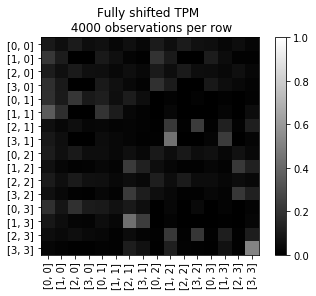

In [6]:
states = Helpers.get_nary_states(2,4)
states = [str(list(reversed(state))) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(TPM_offset,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Fully shifted TPM \n 4000 observations per row")
plt.colorbar()

### Let's get the macro TPM now, and compare Phi values

In [9]:
num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
coarse_grained_TPM_offset = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM_offset, state_map, num_states_per_elem)


<Figure size 432x288 with 0 Axes>

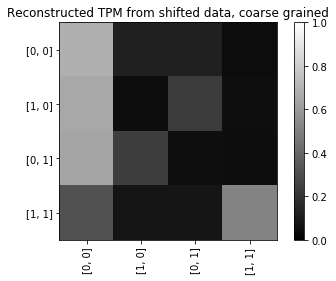

<Figure size 432x288 with 0 Axes>

In [11]:
states = Helpers.get_nary_states(2,2)
states = [str(list(reversed(state))) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(coarse_grained_TPM_offset,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Reconstructed TPM from shifted data, coarse grained")
plt.colorbar()
plt.figure()


In [7]:
micro_phi_shifted = PhiCalculator.get_micro_average_phi(TPM_offset, verbose=False)
macro_phi_shifted = PhiCalculator.get_macro_average_phi(TPM_offset, verbose=False)

In [13]:
micro_phi_shifted, macro_phi_shifted

(0.33555962500000003, 0.28660500000000005)